### Step 1: Import Libraries


We’ll import all the required libraries for:

- Data handling → os, numpy, pandas

- Image processing → cv2, PIL

- ML pipeline → scikit-learn

- Visualization → matplotlib, seaborn

In [15]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm  
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


### Step 2: Load Dataset

The EuroSAT_RGB dataset is organized into folders — each folder name = class name.

So we will:

- skip hidden folders and non-image files,

- load each image once, resize to IMG_SIZE,

- compute compact features per image: color histogram (3 channels, 16 bins → 48 features) + per-channel mean & std (6 features) → total 54 features per image (small and effective),

- build X, y per image (not per pixel),

- avoid memory blow-up.

In [5]:
DATASET_DIR = r"..\eurosat_rgb"   
IMG_SIZE = 64    
HIST_BINS = 16  

def is_image_file(filename):
    ext = filename.lower().split('.')[-1]
    return ext in ('jpg','jpeg','png','tif','tiff','bmp')

def extract_features_from_image(img, hist_bins=16):
    # 1) color histograms per channel (normalized)
    chans = cv2.split(img)
    hist_features = []
    for ch in chans:
        hist = cv2.calcHist([ch], [0], None, [hist_bins], [0,256])
        hist = hist.flatten()
        hist = hist / (hist.sum() + 1e-8)   
        hist_features.append(hist)
    hist_features = np.concatenate(hist_features)  

    # 2) per-channel mean and std
    means = [ch.mean() for ch in chans]
    stds  = [ch.std()  for ch in chans]

    # Combine
    feat = np.concatenate([hist_features, means, stds])
    return feat

X = []
y = []
classes = []
image_count = 0

for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    classes.append(class_name)
    for fname in tqdm(sorted(os.listdir(class_path)), desc=class_name, leave=False):
        if fname.startswith('.') or not is_image_file(fname):
            continue
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        # convert BGR -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        feat = extract_features_from_image(img, hist_bins=HIST_BINS)
        X.append(feat)
        y.append(class_name)
        image_count += 1

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=object)

print("✅ Loaded images:", image_count)
print("Feature matrix shape:", X.shape)
print("Classes:", classes)


✅ Loaded images: 27000
Feature matrix shape: (27000, 54)
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Step 3: Feature Extraction Recap

Transform each image into numerical features.\
✅ Already done in your previous code → 54 features per image (color histograms + mean + std).


In [6]:
print(f"✅ Feature extraction complete — total samples: {len(X)}, feature size: {X.shape[1]}")


✅ Feature extraction complete — total samples: 27000, feature size: 54


### Step 4: Normalization

Standardize feature ranges so no feature dominates others.\
We’ll use StandardScaler() → mean = 0, std = 1.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features normalized.")
print("Mean (after scaling):", np.round(X_scaled.mean(), 4))
print("Std (after scaling):", np.round(X_scaled.std(), 4))


✅ Features normalized.
Mean (after scaling): 0.0
Std (after scaling): 1.0


### Step 5: Dimensionality Reduction (PCA)

Reduce the 54-dimensional feature space while retaining ~95% of the information.\
This speeds up KNN and avoids redundant correlations between histogram bins.


**Why PCA?**

EuroSAT features (histograms + mean/std) can be correlated. PCA finds the main “directions” (principal components) that explain most variance in the data.

**How it works:**

PCA computes orthogonal axes that summarize data → fewer dimensions, same structure.



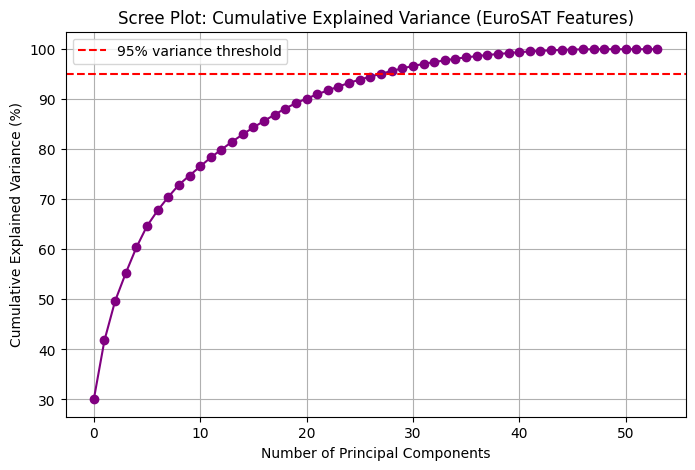

✅ PCA applied successfully.
Original feature size: 54
Reduced feature size:  28
Total explained variance: 95.09%


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# visualize variance explained by PCA
pca_test = PCA()
pca_test.fit(X_scaled)

explained_variance_ratio = np.cumsum(pca_test.explained_variance_ratio_) * 100

plt.figure(figsize=(8,5))
plt.plot(explained_variance_ratio, marker='o', color='purple')
plt.axhline(y=95, color='r', linestyle='--', label='95% variance threshold')
plt.title("Scree Plot: Cumulative Explained Variance (EuroSAT Features)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.legend()
plt.show()

# Choose components explaining 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Display summary
print("✅ PCA applied successfully.")
print(f"Original feature size: {X_scaled.shape[1]}")
print(f"Reduced feature size:  {X_pca.shape[1]}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")


### Step 6 — Train/Test Split

Before training, we divide our reduced dataset into:

- Training set (80%) → used to train the model

- Testing set (20%) → used to evaluate how well it generalizes

We stratify the split to keep class balance (important since some EuroSAT classes have slightly different sample counts).

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print("✅ Data successfully split.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")


✅ Data successfully split.
Training samples: 21600
Testing samples:  5400


### Step 7 — Train & Optimize KNN (with GridSearchCV)

The KNN algorithm depends mainly on K (number of neighbors) and distance metric.\
To reach high accuracy, we use GridSearchCV to test different values automatically:

- n_neighbors: 3 → 11

- weights: 'uniform', 'distance'

- metric: 'euclidean', 'manhattan'

We’ll use 5-fold cross-validation.

In [10]:
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearch with 5-fold CV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters
best_knn = grid_search.best_estimator_

print("✅ GridSearch complete.")
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ GridSearch complete.
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-Validation Accuracy: 74.23%


C:\Users\APL TECH\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.73296296 0.7337963  0.73796296 0.74111111 0.73717593 0.73925926
 0.73356481 0.73824074 0.73013889 0.73546296        nan 0.73490741
        nan 0.74231481        nan 0.74217593        nan 0.73902778
        nan 0.7374537 ]
  warnings.warn(


### Step 8 — Evaluation

We now test our optimized best_knn model on X_test and compare predicted vs true classes.
We’ll compute:

- Accuracy

- Confusion Matrix

- Classification Report (Precision, Recall, F1)

- Cohen’s Kappa — measures agreement beyond random chance.

✅ Test Accuracy: 75.24%
🧩 Kappa Coefficient: 0.724

Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop      0.858     0.677     0.757       600
              Forest      0.890     0.928     0.909       600
HerbaceousVegetation      0.701     0.677     0.689       600
             Highway      0.470     0.370     0.414       500
          Industrial      0.855     0.894     0.874       500
             Pasture      0.771     0.833     0.800       400
       PermanentCrop      0.589     0.684     0.633       500
         Residential      0.675     0.910     0.775       600
               River      0.722     0.622     0.668       500
             SeaLake      0.960     0.883     0.920       600

            accuracy                          0.752      5400
           macro avg      0.749     0.748     0.744      5400
        weighted avg      0.755     0.752     0.749      5400



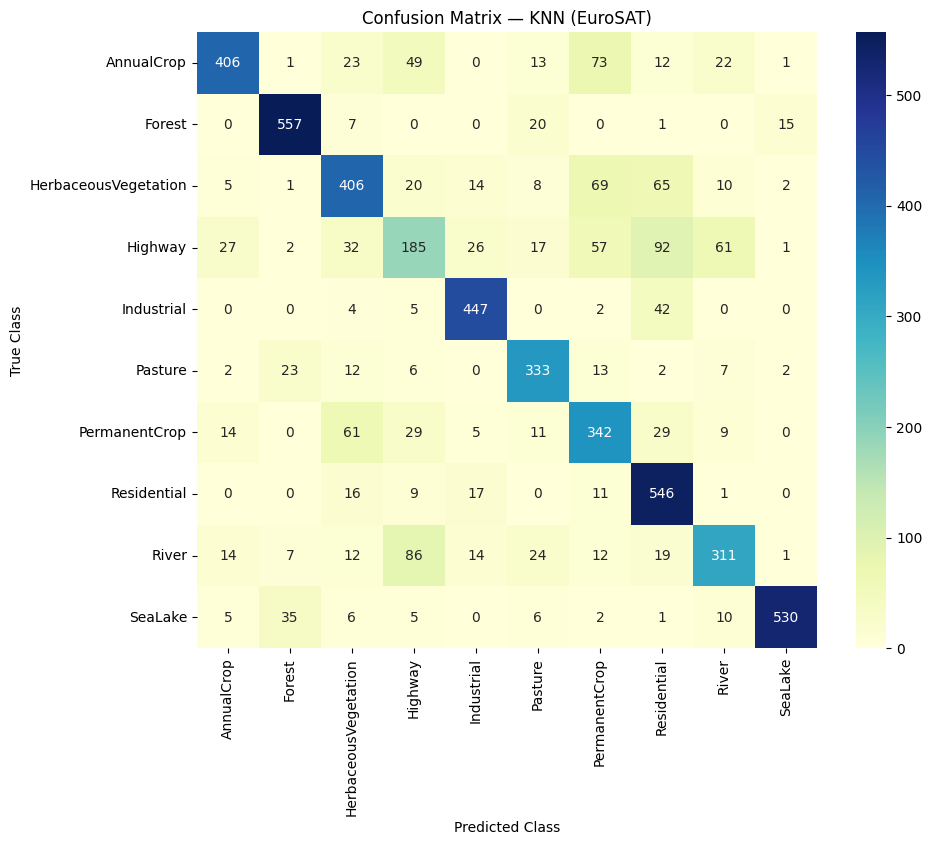

In [11]:
# Predict on test set
y_pred = best_knn.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"✅ Test Accuracy: {acc*100:.2f}%")
print(f"🧩 Kappa Coefficient: {kappa:.3f}")
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=best_knn.classes_,
            yticklabels=best_knn.classes_)
plt.title("Confusion Matrix — KNN (EuroSAT)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


### Step 9 — Error Validation (Satellite Authenticity Check)

Sometimes, a model may receive non-satellite or corrupted images.\
We can quickly validate inputs by checking:

- Average brightness and color variance (to reject grayscale/flat images)

- Pixel range (should be within [0, 255])

- Optional spectral check if IR exists (values within expected range)

In [12]:
def validate_satellite_image(img_path):
    """Check if an input image likely comes from a satellite source."""
    img = cv2.imread(img_path)
    if img is None:
        return False, "❌ Cannot open image file."

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_val = np.mean(img)
    std_val  = np.std(img)

    if img.ndim != 3 or img.shape[2] < 3:
        return False, "❌ Image not RGB."

    if not (10 < mean_val < 245):
        return False, f"⚠️ Brightness abnormal: mean={mean_val:.1f}"

    if std_val < 10:
        return False, f"⚠️ Very low variance (probably grayscale): std={std_val:.1f}"

    return True, f"✅ Image validated (mean={mean_val:.1f}, std={std_val:.1f})"

ok, msg = validate_satellite_image(r'../fake_image.jpg')
print(msg)


✅ Image validated (mean=63.7, std=110.4)


### Step 10 — Prediction Output (Visual Classification)

Finally, we can visualize predictions for random test samples to verify the model visually.

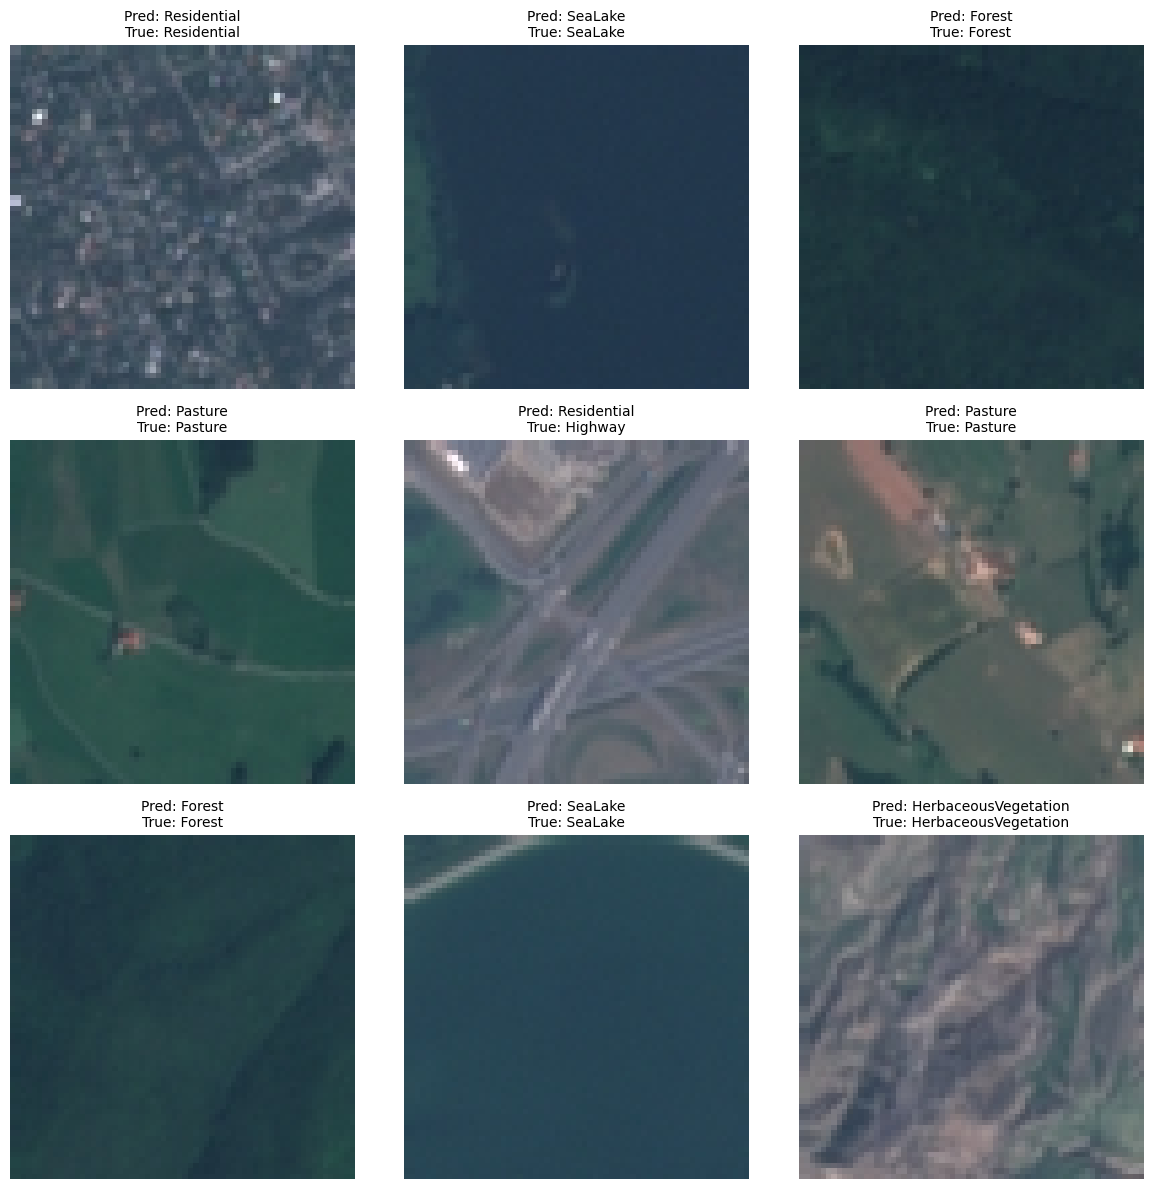

In [13]:
import random

n_samples = 9
indices = random.sample(range(len(X_test)), n_samples)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices, 1):
    sample_features = X_test[idx].reshape(1, -1)
    pred_class = best_knn.predict(sample_features)[0]
    true_class = y_test[idx]

    # Show one of the original training images from that class (approx)
    class_folder = os.path.join(DATASET_DIR, true_class)
    example_path = random.choice([
        os.path.join(class_folder, f) for f in os.listdir(class_folder)
        if is_image_file(f)
    ])
    img = cv2.imread(example_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Step 10 — Advanced Prediction, Visualization & Optimization

In [14]:


def visualize_preprocessing(img_path):
    """Show original, normalized, and filtered versions of a satellite image."""
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print("❌ Cannot open image file.")
        return
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb / 255.0
    img_filtered = cv2.medianBlur((img_rgb).astype(np.uint8), 3)

    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    titles = ["Original", "Normalized", "Median Filtered"]
    imgs = [img_rgb, img_norm, img_filtered]

    for ax, title, im in zip(axes, titles, imgs):
        ax.imshow(im)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle("🛰️ Image Preprocessing Visualization", fontsize=14)
    plt.show()


**Predict with confidence + show other top classes**

In [16]:
def predict_satellite_image(knn_model, img_path, class_names, scaler, pca):
    """Predict class and confidence for a given satellite image."""
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Cannot open image.")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img.astype("float32") / 255.0
    img_flat = img.reshape(-1, 3)

    # Apply same PCA pipeline
    img_pca = pca.transform(img_flat)
    img_scaled = scaler.transform(img_pca)
    img_mean = np.mean(img_scaled, axis=0).reshape(1, -1)

    probs = knn_model.predict_proba(img_mean)[0]
    top_indices = np.argsort(probs)[::-1][:3]  # top 3 predictions
    main_class = class_names[top_indices[0]]
    confidence = probs[top_indices[0]] * 100

    print(f"🛰️ Predicted class: {main_class} ({confidence:.2f}%)")
    print("📊 Other probable classes:")
    for i in top_indices:
        print(f"  • {class_names[i]}: {probs[i]*100:.2f}%")

    # Visualization
    plt.imshow(img)
    plt.title(f"Prediction: {main_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()

    return main_class, confidence


**Save model for reuse**

In [ ]:
joblib.dump(best_knn, "knn_eurosat_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(classes, "class_names.pkl")

print("✅ Model, scaler, and PCA saved successfully.")

✅ Model, scaler, and PCA saved successfully.


['knn_eurosat_model.pkl']